# Baseline XGBoost Classifier - Soccer O/U 2.5 Goals Prediction

**Objective**: Build and evaluate a baseline XGBoost classifier using core soccer match features to predict Over/Under 2.5 goals.

**Tasks**:
- Load baseline preprocessed data
- Build baseline XGBoost classifier  
- Train and validate model
- Hyperparameter tuning
- Feature importance analysis
- Performance comparison (tuned vs untuned)
- XGBoost vs Random Forest comparison

## 1. Setup and Data Loading

### 1.1 Import Libraries

In [7]:
# Core libraries
import pandas as pd
import numpy as np
import pickle
import time
import os
import warnings
warnings.filterwarnings('ignore', category=Warning) # Suppress convergence warnings from Gaussian Process

# Hyperparameter optimization
import optuna
from optuna.samplers import TPESampler

# XGBoost
import xgboost as xgb
from xgboost import plot_importance, plot_tree

# Machine Learning Utilities
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve, ShuffleSplit
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve, log_loss
)

# Bayesian Optimization
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)

# Configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### 1.2 Evaluation function

In [8]:
# Function to calculate comprehensive metrics
def evaluate_model(y_true, y_pred, y_pred_proba, model_name="Model"):
    """Calculate comprehensive classification metrics"""
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'log_loss': log_loss(y_true, y_pred_proba),
        'roc_auc': roc_auc_score(y_true, y_pred_proba)
    }
    
    print(f"\n📈 {model_name} Performance Metrics:")
    print("=" * 50)
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1']:.4f}")
    print(f"Log Loss:   {metrics['log_loss']:.4f}")
    print(f"ROC-AUC:   {metrics['roc_auc']:.4f}")
    
    return metrics

### 1.3 Load Baseline Preprocessed Data

In [9]:
# Load the baseline preprocessed data

with open('./outputs/processed/baseline_preprocessed.pkl', 'rb') as f:
    baseline_data = pickle.load(f)

# Extract all datasets including validation set
X_train_baseline = baseline_data['X_train']
X_val_baseline = baseline_data['X_val']
X_test_baseline = baseline_data['X_test'] 
y_train = baseline_data['y_train']
y_val = baseline_data['y_val']
y_test = baseline_data['y_test']

print(f"\n📊 Dataset Shapes:")
print(f"Training set: {X_train_baseline.shape}")
print(f"Validation set: {X_val_baseline.shape}")
print(f"Test set: {X_test_baseline.shape}")
print(f"Features: {X_train_baseline.shape[1]}")

print(f"\n🎯 Target Distribution:")
print(f"Training - Over 2.5: {y_train.mean():.2%}")
print(f"Validation - Over 2.5: {y_val.mean():.2%}")
print(f"Test - Over 2.5: {y_test.mean():.2%}")


# Display data split summary
total_samples = len(y_train) + len(y_val) + len(y_test)
print(f"\n📈 Data Split Summary:")
print(f"Total samples: {total_samples:,}")
print(f"Training: {len(y_train):,} ({len(y_train)/total_samples:.1%})")
print(f"Validation: {len(y_val):,} ({len(y_val)/total_samples:.1%})")
print(f"Test: {len(y_test):,} ({len(y_test)/total_samples:.1%})")


📊 Dataset Shapes:
Training set: (28217, 344)
Validation set: (7247, 344)
Test set: (7129, 344)
Features: 344

🎯 Target Distribution:
Training - Over 2.5: 49.00%
Validation - Over 2.5: 53.14%
Test - Over 2.5: 50.69%

📈 Data Split Summary:
Total samples: 42,593
Training: 28,217 (66.2%)
Validation: 7,247 (17.0%)
Test: 7,129 (16.7%)


## 2 Modeling

### 2.1 Baseline model

In [10]:
# Create baseline XGBoost classifier with default parameters

# Initialize XGBoost with basic parameters
xgb_baseline = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0  # Suppress training output
)


# Train the baseline XGBoost model
xgb_baseline.fit(X_train_baseline, y_train)


# Make predictions on validation set
y_val_pred_baseline = xgb_baseline.predict(X_val_baseline)
y_val_pred_proba_baseline = xgb_baseline.predict_proba(X_val_baseline)[:, 1]


# Evaluate baseline model
baseline_metrics = evaluate_model(
    y_val, y_val_pred_baseline, y_val_pred_proba_baseline, 
    "Baseline XGBoost (Validation)"
)



📈 Baseline XGBoost (Validation) Performance Metrics:
Accuracy:  0.5393
Precision: 0.5706
Recall:    0.5370
F1-Score:  0.5533
Log Loss:   0.7660
ROC-AUC:   0.5495


## 2.2 Hyperparameter Optimization with Optuna

#### 2.2.1 Definition of optimized parameters and training training-validation function

In [11]:





def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization
    Returns: log loss score to maximize
    """
    
    # Define hyperparameter search space
    params = {
        'objective': 'binary:logistic',
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'verbosity': 0,
        
        # Tree structure parameters - adjusted for high dimensions (344+ features)
        'max_depth': trial.suggest_int('max_depth', 4, 30),
        'min_child_weight': trial.suggest_int('min_child_weight', 3, 20),
        
        # Sampling parameters - crucial for high dimensions
        'subsample': trial.suggest_float('subsample', 0.7, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.8),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 0.9),
        
        # Boosting parameters
        'n_estimators': trial.suggest_int('n_estimators', 100, 4000, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.8, log=True),
        
        # Regularization parameters - stronger for high dimensions
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 20.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 50.0),
        
        # Advanced parameters
        'gamma': trial.suggest_float('gamma', 0.1, 10.0),
    }
    
    # Create and train model
    model = xgb.XGBClassifier(**params)
    model.fit(X_train_baseline, y_train)
    
    # Predict on validation set
    y_pred_proba = model.predict_proba(X_val_baseline)[:, 1]  # Extract positive class probabilities
    
    # Return negative log loss (higher is better since we minimize log loss)
    logloss = log_loss(y_val, y_pred_proba)
    
    return -logloss



#### 2.2.2 Running optuna optimization with 250 trials

In [12]:
### 3.3 Run Hyperparameter Optimization

# Create study with TPE sampler for efficient search
study = optuna.create_study(
    direction='maximize',  # We want to minimize log loss (maximize negative log loss)
    sampler=TPESampler(seed=RANDOM_STATE),
    study_name='xgboost_soccer_prediction'
)

# Record start time
start_time = time.time()

# Run optimization with more trials for high-dimensional space
N_TRIALS = 250  # More trials needed for complex parameter space with 344+ features
print(f"🚀 Running {N_TRIALS} trials for high-dimensional optimization...")

study.optimize(objective, n_trials=N_TRIALS)

# Calculate optimization time
optimization_time = time.time() - start_time

print(f"✅ Optimization completed in {optimization_time:.1f} seconds")
print(f"📊 Best Log Loss: {-study.best_value:.6f}")
print(f"🏆 Best trial: #{study.best_trial.number}")


[I 2025-11-16 17:19:28,502] A new study created in memory with name: xgboost_soccer_prediction


🚀 Running 250 trials for high-dimensional optimization...


[I 2025-11-16 17:19:31,375] Trial 0 finished with value: -0.6833304482143208 and parameters: {'max_depth': 14, 'min_child_weight': 20, 'subsample': 0.8829984854528512, 'colsample_bytree': 0.5190609389379257, 'colsample_bylevel': 0.22481491235394924, 'n_estimators': 700, 'learning_rate': 0.006714184244399761, 'reg_alpha': 17.33690530092121, 'reg_lambda': 30.45463557541723, 'gamma': 7.10991852018085}. Best is trial 0 with value: -0.6833304482143208.
[I 2025-11-16 17:19:33,688] Trial 1 finished with value: -0.6822583460815317 and parameters: {'max_depth': 4, 'min_child_weight': 20, 'subsample': 0.9081106602001054, 'colsample_bytree': 0.24863737747479334, 'colsample_bylevel': 0.24545997376568052, 'n_estimators': 800, 'learning_rate': 0.023418356423825146, 'reg_alpha': 10.542652989481532, 'reg_lambda': 22.165305913463673, 'gamma': 2.983168487960615}. Best is trial 1 with value: -0.6822583460815317.
[I 2025-11-16 17:20:16,592] Trial 2 finished with value: -0.7058835260135259 and parameters: 

✅ Optimization completed in 1212.8 seconds
📊 Best Log Loss: 0.680009
🏆 Best trial: #216


#### 2.2.3 Best parameters according to optuna

In [13]:
# The best found hyperparameters
print("📋 Best hyperparameters:")
for param, value in study.best_params.items():
    print(f"   {param}: {value}")

📋 Best hyperparameters:
   max_depth: 12
   min_child_weight: 6
   subsample: 0.7445934113622394
   colsample_bytree: 0.5540251387183303
   colsample_bylevel: 0.12988265398616483
   n_estimators: 2800
   learning_rate: 0.005017153468595737
   reg_alpha: 0.6601442412564509
   reg_lambda: 2.3405138906143357
   gamma: 6.894783009186152


## 2.2 Hyperparameter Optimization with manual Bayesian Optimization

In [14]:


# --------------------------------------------
#  Define objective function (same as Optuna)
# --------------------------------------------
def evaluate_xgb_manual(params):
    """Train XGBoost and evaluate Log Loss on validation - matches Optuna objective."""
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=0,
        # Parameters in same order as bounds array
        max_depth=int(params[0]),
        min_child_weight=int(params[1]),
        subsample=params[2],
        colsample_bytree=params[3],
        colsample_bylevel=params[4],
        n_estimators=int(params[5]),
        learning_rate=params[6],
        reg_alpha=params[7],
        reg_lambda=params[8],
        gamma=params[9]
    )

    model.fit(X_train_baseline, y_train)
    y_pred_val = model.predict_proba(X_val_baseline)[:, 1]  # Extract positive class probabilities
    logloss = log_loss(y_val, y_pred_val)
    # We minimize log loss directly
    return logloss

# --------------------------------------------
#  Define search space bounds (matching Optuna exactly)
# --------------------------------------------
param_bounds = np.array([
    [4, 30],         # max_depth: 4-30
    [3, 20],         # min_child_weight: 3-20
    [0.7, 0.95],     # subsample: 0.7-0.95
    [0.1, 0.8],      # colsample_bytree: 0.1-0.8
    [0.1, 0.9],      # colsample_bylevel: 0.1-0.9
    [100, 4000],     # n_estimators: 100-4000
    [0.005, 0.8],    # learning_rate: 0.005-0.8
    [0.1, 20.0],     # reg_alpha: 0.1-20.0
    [1.0, 50.0],     # reg_lambda: 1.0-50.0
    [0.1, 10.0],     # gamma: 0.1-10.0
])

n_params = param_bounds.shape[0]

# --------------------------------------------
#  Initialize samples (random warm-up)
# --------------------------------------------
np.random.seed(RANDOM_STATE)
N_INIT = 15  # More initial samples for 10-dimensional space


X_samples = np.random.uniform(param_bounds[:, 0], param_bounds[:, 1], size=(N_INIT, n_params))
Y_samples = np.array([evaluate_xgb_manual(x) for x in X_samples])

# --------------------------------------------
#  Fit Gaussian Process surrogate
# --------------------------------------------
kernel = Matern(length_scale=1.0, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=RANDOM_STATE)

# Scaler helps GP fit parameters of different magnitudes 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_samples)
gp.fit(X_scaled, Y_samples)

# --------------------------------------------
#  Acquisition function (Upper Confidence Bound)
# --------------------------------------------
def acquisition_ucb(X, model, kappa=2.0):
    """Upper Confidence Bound acquisition function"""
    mu, sigma = model.predict(X, return_std=True)
    return mu - kappa * sigma  # minimizing log loss

def propose_next(model, bounds, n_candidates=3000):
    """Propose next point to evaluate"""
    candidates = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_candidates, bounds.shape[0]))
    candidates_scaled = scaler.transform(candidates)
    acq_vals = acquisition_ucb(candidates_scaled, model)
    best_idx = np.argmin(acq_vals)
    return candidates[best_idx].reshape(1, -1), np.min(acq_vals)

# --------------------------------------------
#  Iterative Bayesian Optimization loop
# --------------------------------------------
N_ITER = 250  # More iterations again to match Optuna's exploration capacity
history_best = [np.min(Y_samples)]

print(f"\n🚀 Starting Bayesian Optimization with {N_ITER} iterations...")
start_time = time.time()

for i in range(N_ITER):
    # Propose next point
    x_next, acq_val = propose_next(gp, param_bounds)
    y_next = evaluate_xgb_manual(x_next[0])
    
    # Update datasets
    X_samples = np.vstack([X_samples, x_next])
    Y_samples = np.hstack([Y_samples, y_next])

    # Refit Gaussian Process
    X_scaled = scaler.fit_transform(X_samples)
    gp.fit(X_scaled, Y_samples)

    # Track progress
    history_best.append(np.min(Y_samples))
    current_best_logloss = np.min(Y_samples)
    
    if (i + 1) % 10 == 0 or i < 5:  # Print progress every 10 iterations
        print(f"Iteration {i+1:02d}: Best Log Loss = {current_best_logloss:.5f}")

optimization_time = time.time() - start_time

# --------------------------------------------
#  Final results and comparison
# --------------------------------------------
best_idx = np.argmin(Y_samples)
best_params_array = X_samples[best_idx]
best_logloss = Y_samples[best_idx]



# Create parameter dictionary in same format as Optuna
param_names = ["max_depth", "min_child_weight", "subsample", "colsample_bytree",
               "colsample_bylevel", "n_estimators", "learning_rate", "reg_alpha",
               "reg_lambda", "gamma"]

# Convert to dictionary format matching Optuna output
manual_bo_params = {}
for i, name in enumerate(param_names):
    if name in ["max_depth", "min_child_weight", "n_estimators"]:
        manual_bo_params[name] = int(best_params_array[i])
    else:
        manual_bo_params[name] = float(best_params_array[i])

print(f"\n📋 Best hyperparameters found:")
for name, val in manual_bo_params.items():
    if isinstance(val, int):
        print(f"  {name:18}: {val}")
    else:
        print(f"  {name:18}: {val:.4f}")



print(f"\n🏆 Manual Bayesian Optimization Results:")
print(f"⏱️  Optimization time: {optimization_time:.1f} seconds")
print(f"🎯 Best validation Log Loss: {best_logloss:.6f}")
print(f"📊 Total evaluations: {len(Y_samples)}")



🚀 Starting Bayesian Optimization with 250 iterations...
Iteration 01: Best Log Loss = 0.68279
Iteration 02: Best Log Loss = 0.68279
Iteration 03: Best Log Loss = 0.68279
Iteration 04: Best Log Loss = 0.68279
Iteration 05: Best Log Loss = 0.68279
Iteration 10: Best Log Loss = 0.68274
Iteration 20: Best Log Loss = 0.68250
Iteration 30: Best Log Loss = 0.68121
Iteration 40: Best Log Loss = 0.68121
Iteration 50: Best Log Loss = 0.68121
Iteration 60: Best Log Loss = 0.68121
Iteration 70: Best Log Loss = 0.68121
Iteration 80: Best Log Loss = 0.68121
Iteration 90: Best Log Loss = 0.68121
Iteration 100: Best Log Loss = 0.68121
Iteration 110: Best Log Loss = 0.68121
Iteration 120: Best Log Loss = 0.68121
Iteration 130: Best Log Loss = 0.68121
Iteration 140: Best Log Loss = 0.68121
Iteration 150: Best Log Loss = 0.68121
Iteration 160: Best Log Loss = 0.68121
Iteration 170: Best Log Loss = 0.68121
Iteration 180: Best Log Loss = 0.68121
Iteration 190: Best Log Loss = 0.68121
Iteration 200: Best L

## 2.3 Comparison of optuna vs manual

#### 2.3.1 Best parameters according to both approaches

In [15]:

# Extract best parameters from Optuna study
optuna_params = study.best_params
optuna_logloss = -study.best_value

print(f"\n📊 Comparison of Best Hyperparameters:")
print(f"{'Parameter':<18} {'Optuna':<15}        {'Manual BO':<15}")
print("-" * 50)

for param in param_names:
    optuna_val = optuna_params.get(param, 'N/A')
    manual_val = manual_bo_params.get(param, 'N/A')
    
    if isinstance(manual_val, int):
        print(f"{param:<18} {optuna_val:<15}              {manual_val:<15}")
    else:
        
        print(f"{param:<18} {optuna_val:<15}         {manual_val:.4f}")

print(f"\n🎯 Best Log Loss Comparison:")
print(f"Optuna Log Loss:    {optuna_logloss:.6f}")
print(f"Manual BO Log Loss: {best_logloss:.6f}")
print(f"Difference:    {abs(optuna_logloss - best_logloss):.6f}")




📊 Comparison of Best Hyperparameters:
Parameter          Optuna                 Manual BO      
--------------------------------------------------
max_depth          12                           29             
min_child_weight   6                            18             
subsample          0.7445934113622394         0.9202
colsample_bytree   0.5540251387183303         0.2293
colsample_bylevel  0.12988265398616483         0.1655
n_estimators       2800                         1563           
learning_rate      0.005017153468595737         0.0512
reg_alpha          0.6601442412564509         1.2659
reg_lambda         2.3405138906143357         2.7366
gamma              6.894783009186152         5.2724

🎯 Best Log Loss Comparison:
Optuna Log Loss:    0.680009
Manual BO Log Loss: 0.681211
Difference:    0.001202


## 2.4 Training Models with optimized parameters 

In [16]:


# Model trained with Optuna best parameters
xgb_optuna = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0,
    **optuna_params
)

xgb_optuna.fit(X_train_baseline, y_train)
y_pred_val_optuna = xgb_optuna.predict_proba(X_val_baseline)[:, 1]
log_loss_optuna = log_loss(y_val, y_pred_val_optuna)
print(f"✅ Optuna model Log Loss: {log_loss_optuna:.6f}")

# Model trained with Manual Bayesian Optimization best parameters  
xgb_manual = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0,
    **manual_bo_params
)

xgb_manual.fit(X_train_baseline, y_train)
y_pred_val_manual = xgb_manual.predict_proba(X_val_baseline)[:, 1]  # Extract positive class probabilities
log_loss_manual = log_loss(y_val, y_pred_val_manual)
print(f"✅ Manual BO model Log Loss: {log_loss_manual:.6f}")

print(f"\n📊 Final Validation Results (Optimized for Log Loss):")
print(f"Baseline XGBoost:     Log Loss = {baseline_metrics['log_loss']:.6f} | Accuracy = {baseline_metrics['accuracy']:.6f}")
print(f"Optuna Optimized:     Log Loss = {log_loss_optuna:.6f} | Accuracy = {accuracy_score(y_val, (y_pred_val_optuna >= 0.5).astype(int)):.6f}")
print(f"Manual BO Optimized:  Log Loss = {log_loss_manual:.6f} | Accuracy = {accuracy_score(y_val, (y_pred_val_manual >= 0.5).astype(int)):.6f}")
print(f"\n🏆 Best Log Loss: {min(baseline_metrics['log_loss'], log_loss_optuna, log_loss_manual):.6f}")    



✅ Optuna model Log Loss: 0.680009
✅ Manual BO model Log Loss: 0.681211

📊 Final Validation Results (Optimized for Log Loss):
Baseline XGBoost:     Log Loss = 0.766028 | Accuracy = 0.539258
Optuna Optimized:     Log Loss = 0.680009 | Accuracy = 0.562578
Manual BO Optimized:  Log Loss = 0.681211 | Accuracy = 0.559404

🏆 Best Log Loss: 0.680009


## 2.5 Final Model Training on Train + Validation Data

**Important Methodological Note:**

While hyperparameters were optimized using:
- **Training data**: 2019-2023 seasons (for model fitting during optimization)
- **Validation data**: 2023/2024 season (for hyperparameter selection)

The **final models** for test evaluation are retrained on the **combined train+validation dataset** (2019-2024) to:
1. ✅ Use all available historical data before predicting 2024/2025
2. ✅ Provide maximum seasonal context (5 full seasons vs 4)
3. ✅ Follow best practices for time-series ML: tune on historical splits, then retrain on all available data before final deployment/evaluation

This is standard practice and does NOT introduce data leakage since:
- Hyperparameters were selected using only train data (2019-2023)
- The test set (2024/2025) was never seen during optimization
- We're simply using more historical data to make better predictions on unseen future data

In [17]:
# Combine training and validation data for final model training
print("=" * 70)
print("COMBINING TRAIN + VALIDATION DATA FOR FINAL MODELS")
print("=" * 70)

X_train_full = pd.concat([X_train_baseline, X_val_baseline], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

# Reset index
X_train_full.reset_index(drop=True, inplace=True)
y_train_full.reset_index(drop=True, inplace=True)

print(f"\nCombined Training Data:")
print(f"Features: {X_train_full.shape}")
print(f"Over 2.5 rate: {y_train_full.mean():.2%}")
print(f"Total samples: {len(y_train_full):,}")

COMBINING TRAIN + VALIDATION DATA FOR FINAL MODELS

Combined Training Data:
Features: (35464, 344)
Over 2.5 rate: 49.85%
Total samples: 35,464


### 2.5.1 Retrain Baseline Model on Full Training Data

In [18]:
# Retrain baseline model on combined train+val data
xgb_baseline_final = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0
)

print("\n🔄 Retraining Baseline XGBoost on Train+Val...")
xgb_baseline_final.fit(X_train_full, y_train_full)
print("✅ Baseline model retrained")


🔄 Retraining Baseline XGBoost on Train+Val...
✅ Baseline model retrained


### 2.5.2 Retrain Optuna Model on Full Training Data

In [19]:
# Retrain Optuna model on combined train+val data with best hyperparameters
xgb_optuna_final = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0,
    **optuna_params
)

print("\n🔄 Retraining Optuna-Optimized XGBoost on Train+Val...")
xgb_optuna_final.fit(X_train_full, y_train_full)
print("✅ Optuna model retrained with optimized hyperparameters")


🔄 Retraining Optuna-Optimized XGBoost on Train+Val...
✅ Optuna model retrained with optimized hyperparameters


### 2.5.3 Retrain Manual BO Model on Full Training Data

In [20]:
# Retrain Manual BO model on combined train+val data with best hyperparameters
xgb_manual_final = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0,
    **manual_bo_params
)

print("\n🔄 Retraining Manual BO XGBoost on Train+Val...")
xgb_manual_final.fit(X_train_full, y_train_full)
print("✅ Manual BO model retrained with optimized hyperparameters")

print("\n" + "=" * 70)
print("ALL MODELS RETRAINED ON FULL TRAINING DATA (2019-2024)")
print("Ready for test set evaluation on 2024/2025 season")
print("=" * 70)


🔄 Retraining Manual BO XGBoost on Train+Val...
✅ Manual BO model retrained with optimized hyperparameters

ALL MODELS RETRAINED ON FULL TRAINING DATA (2019-2024)
Ready for test set evaluation on 2024/2025 season


# 3 Analysis

## 3.1 Feature Importance in All Three Final Models (Trained on Train+Val)

<Figure size 1200x800 with 0 Axes>

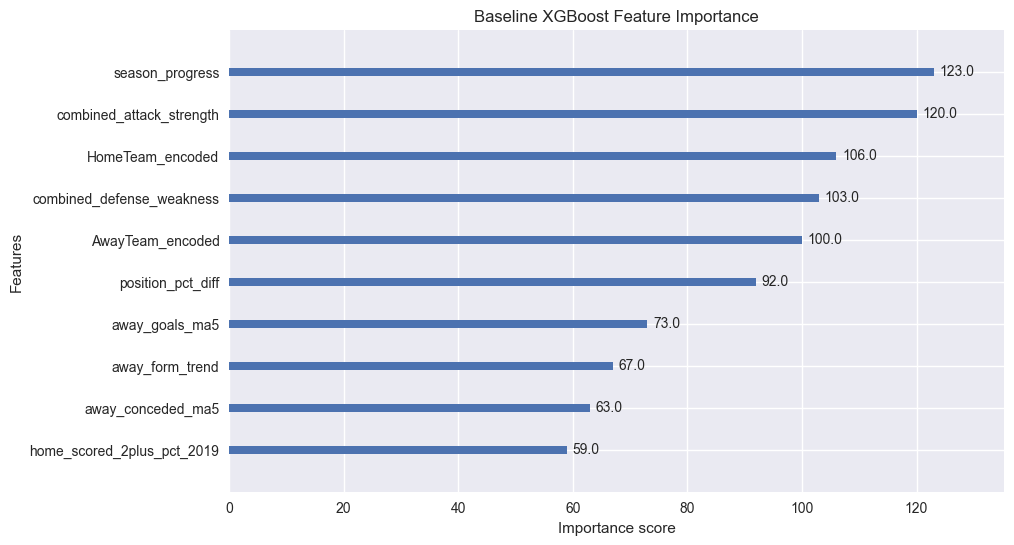

<Figure size 1200x800 with 0 Axes>

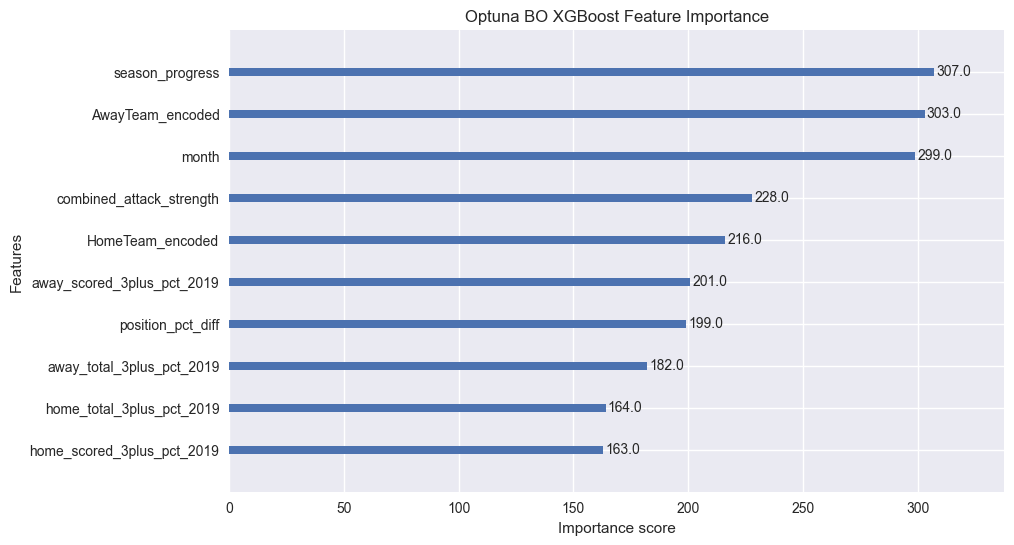

<Figure size 1200x800 with 0 Axes>

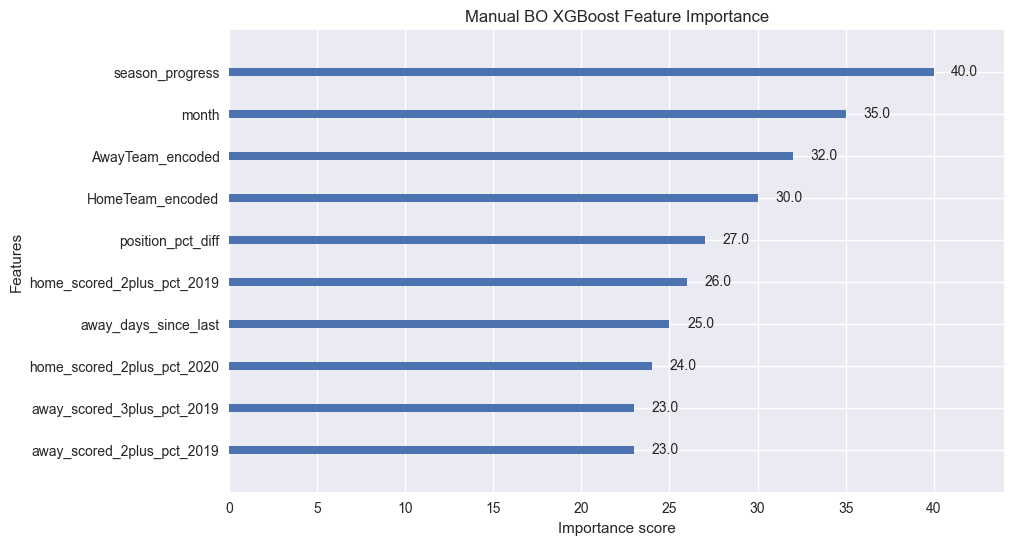

In [21]:


# Plot feature importance for baseline model
plt.figure(figsize=(12, 8))
plot_importance(xgb_baseline, max_num_features=10)
plt.title("Baseline XGBoost Feature Importance")
plt.show()


# Plot feature importance for optuna optimized model
plt.figure(figsize=(12, 8))
plot_importance(xgb_optuna, max_num_features=10)
plt.title("Optuna BO XGBoost Feature Importance")
plt.show()


# Plot feature importance for bayessian optimized model
plt.figure(figsize=(12, 8))
plot_importance(xgb_manual, max_num_features=10)
plt.title("Manual BO XGBoost Feature Importance")
plt.show()


## 3.2 Validation and Test Set Predictions (Final Models Trained on Train+Val)

In [22]:
print("=" * 70)
print("VALIDATION SET PREDICTIONS (Final Models Trained on Train+Val)")
print("=" * 70)

# Validation set predictions
y_pred_val_baseline_final = xgb_baseline_final.predict_proba(X_val_baseline)[:, 1]
log_loss_baseline_val = log_loss(y_val, y_pred_val_baseline_final)
print(f"\n✅ Baseline model VALIDATION Log Loss: {log_loss_baseline_val:.6f}")

y_pred_val_optuna_final = xgb_optuna_final.predict_proba(X_val_baseline)[:, 1]
log_loss_optuna_val = log_loss(y_val, y_pred_val_optuna_final)
print(f"✅ Optuna model VALIDATION Log Loss: {log_loss_optuna_val:.6f}")

y_pred_val_manual_final = xgb_manual_final.predict_proba(X_val_baseline)[:, 1]
log_loss_manual_val = log_loss(y_val, y_pred_val_manual_final)
print(f"✅ Manual BO model VALIDATION Log Loss: {log_loss_manual_val:.6f}")

print("\n" + "=" * 70)
print("TEST SET PREDICTIONS (Final Models Trained on Train+Val)")
print("=" * 70)

# Test set predictions
y_pred_test_baseline = xgb_baseline_final.predict_proba(X_test_baseline)[:, 1]
log_loss_baseline_test = log_loss(y_test, y_pred_test_baseline)
print(f"\n✅ Baseline model TEST Log Loss: {log_loss_baseline_test:.6f}")

y_pred_test_optuna = xgb_optuna_final.predict_proba(X_test_baseline)[:, 1]
log_loss_optuna_test = log_loss(y_test, y_pred_test_optuna)
print(f"✅ Optuna model TEST Log Loss: {log_loss_optuna_test:.6f}")

y_pred_test_manual = xgb_manual_final.predict_proba(X_test_baseline)[:, 1]
log_loss_manual_test = log_loss(y_test, y_pred_test_manual)
print(f"✅ Manual BO model TEST Log Loss: {log_loss_manual_test:.6f}")

VALIDATION SET PREDICTIONS (Final Models Trained on Train+Val)

✅ Baseline model VALIDATION Log Loss: 0.351987
✅ Optuna model VALIDATION Log Loss: 0.647520
✅ Manual BO model VALIDATION Log Loss: 0.643766

TEST SET PREDICTIONS (Final Models Trained on Train+Val)

✅ Baseline model TEST Log Loss: 0.770989
✅ Optuna model TEST Log Loss: 0.688319
✅ Manual BO model TEST Log Loss: 0.691161


## 3.3 Comprehensive Validation and Test Set Evaluation (Final Models - Train+Val)

In [23]:
# Convert probabilities to binary predictions (threshold = 0.5)

# Validation set binary predictions
y_pred_val_baseline_binary = (y_pred_val_baseline_final >= 0.5).astype(int)
y_pred_val_optuna_binary = (y_pred_val_optuna_final >= 0.5).astype(int)
y_pred_val_manual_binary = (y_pred_val_manual_final >= 0.5).astype(int)

# Test set binary predictions
y_pred_test_baseline_binary = (y_pred_test_baseline >= 0.5).astype(int)
y_pred_test_optuna_binary = (y_pred_test_optuna >= 0.5).astype(int)
y_pred_test_manual_binary = (y_pred_test_manual >= 0.5).astype(int)

print("="*80)
print("VALIDATION SET PERFORMANCE (Final Models Trained on Train+Val)")
print("="*80)

print("\n🎯 BASELINE MODEL:")
print(f"Accuracy:  {accuracy_score(y_val, y_pred_val_baseline_binary):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_val_baseline_binary):.4f}")
print(f"Recall:    {recall_score(y_val, y_pred_val_baseline_binary):.4f}")
print(f"F1-Score:  {f1_score(y_val, y_pred_val_baseline_binary):.4f}")
print(f"Log Loss:   {log_loss(y_val, y_pred_val_baseline_final):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_val, y_pred_val_baseline_final):.4f}")

print("\n🎯 OPTUNA OPTIMIZED MODEL:")
print(f"Accuracy:  {accuracy_score(y_val, y_pred_val_optuna_binary):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_val_optuna_binary):.4f}")
print(f"Recall:    {recall_score(y_val, y_pred_val_optuna_binary):.4f}")
print(f"F1-Score:  {f1_score(y_val, y_pred_val_optuna_binary):.4f}")
print(f"Log Loss:   {log_loss(y_val, y_pred_val_optuna_final):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_val, y_pred_val_optuna_final):.4f}")

print("\n🔧 MANUAL BAYESIAN OPTIMIZED MODEL:")
print(f"Accuracy:  {accuracy_score(y_val, y_pred_val_manual_binary):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_val_manual_binary):.4f}")
print(f"Recall:    {recall_score(y_val, y_pred_val_manual_binary):.4f}")
print(f"F1-Score:  {f1_score(y_val, y_pred_val_manual_binary):.4f}")
print(f"Log Loss:   {log_loss(y_val, y_pred_val_manual_final):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_val, y_pred_val_manual_final):.4f}")

print("\n" + "="*80)
print("TEST SET PERFORMANCE (Final Models Trained on Train+Val)")
print("="*80)

print("\n📊 BASELINE MODEL:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test_baseline_binary):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test_baseline_binary):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_test_baseline_binary):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_test_baseline_binary):.4f}")
print(f"Log Loss:   {log_loss(y_test, y_pred_test_baseline):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_test_baseline):.4f}")

print("\n🎯 OPTUNA OPTIMIZED MODEL:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test_optuna_binary):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test_optuna_binary):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_test_optuna_binary):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_test_optuna_binary):.4f}")
print(f"Log Loss:   {log_loss(y_test, y_pred_test_optuna):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_test_optuna):.4f}")

print("\n🔧 MANUAL BAYESIAN OPTIMIZED MODEL:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test_manual_binary):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test_manual_binary):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_test_manual_binary):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_test_manual_binary):.4f}")
print(f"Log Loss:   {log_loss(y_test, y_pred_test_manual):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_test_manual):.4f}")

# Confusion Matrices
print("\n🔢 CONFUSION MATRICES:")
print("\nBaseline Model:")
print(confusion_matrix(y_test, y_pred_test_baseline_binary))
print("\nOptuna Model:")
print(confusion_matrix(y_test, y_pred_test_optuna_binary))
print("\nManual BO Model:")
print(confusion_matrix(y_test, y_pred_test_manual_binary))

VALIDATION SET PERFORMANCE (Final Models Trained on Train+Val)

🎯 BASELINE MODEL:
Accuracy:  0.9375
Precision: 0.9424
Recall:    0.9398
F1-Score:  0.9411
Log Loss:   0.3520
ROC-AUC:   0.9859

🎯 OPTUNA OPTIMIZED MODEL:
Accuracy:  0.6433
Precision: 0.6457
Recall:    0.7284
F1-Score:  0.6846
Log Loss:   0.6475
ROC-AUC:   0.6933

🔧 MANUAL BAYESIAN OPTIMIZED MODEL:
Accuracy:  0.6485
Precision: 0.6517
Recall:    0.7273
F1-Score:  0.6874
Log Loss:   0.6438
ROC-AUC:   0.6987

TEST SET PERFORMANCE (Final Models Trained on Train+Val)

📊 BASELINE MODEL:
Accuracy:  0.5266
Precision: 0.5320
Recall:    0.5495
F1-Score:  0.5406
Log Loss:   0.7710
ROC-AUC:   0.5401

🎯 OPTUNA OPTIMIZED MODEL:
Accuracy:  0.5407
Precision: 0.5352
Recall:    0.7150
F1-Score:  0.6122
Log Loss:   0.6883
ROC-AUC:   0.5731

🔧 MANUAL BAYESIAN OPTIMIZED MODEL:
Accuracy:  0.5386
Precision: 0.5326
Recall:    0.7338
F1-Score:  0.6172
Log Loss:   0.6912
ROC-AUC:   0.5697

🔢 CONFUSION MATRICES:

Baseline Model:
[[1768 1747]
 [1628 1

## 3.4 Classification Report by Country (Using Final Manual BO Model)

In [24]:
# which countries we have based on division prefixes
print("🌍 CLASSIFICATION REPORT BY COUNTRY")
print("=" * 60)

# Extract country information from division columns
div_columns = [col for col in X_test_baseline.columns if col.startswith('Div_')]
print(f"Found {len(div_columns)} division columns")

# Get the active divisions for each match (where value = 1)
countries_data = []
for idx in range(len(X_test_baseline)):
    active_divs = [col.replace('Div_', '') for col in div_columns if X_test_baseline.iloc[idx][col] == 1]
    if active_divs:
        countries_data.append(active_divs[0])  # Take the first (should be only one)
    else:
        countries_data.append('Unknown')

# Create a mapping of common division codes to countries
country_mapping = {
    'B1': 'Belgium', 'D1': 'Germany', 'D2': 'Germany',
    'E0': 'England', 'E1': 'England', 'E2': 'England', 'E3': 'England', 'E4': 'England',
    'F1': 'France', 'F2': 'France',
    'G1': 'Greece', 'I1': 'Italy', 'I2': 'Italy',
    'N1': 'Netherlands', 'P1': 'Portugal',
    'SC0': 'Scotland', 'SC1': 'Scotland', 'SC2': 'Scotland', 'SC3': 'Scotland', 'SC4': 'Scotland',
    'SP1': 'Spain', 'SP2': 'Spain', 'T1': 'Turkey'
}

# Map division codes to country names
countries = [country_mapping.get(div, div) for div in countries_data]

# Get unique countries and their counts
country_counts = pd.Series(countries).value_counts()
print(f"\n📊 Matches per Country:")
for country, count in country_counts.items():
    print(f"   {country}: {count:,} matches")

print(f"\n🎯 CLASSIFICATION REPORTS BY COUNTRY:")
print("=" * 60)

# Generate classification report for each country with sufficient samples
min_samples = 50  # Minimum samples needed for meaningful report
significant_countries = country_counts[country_counts >= min_samples].index

for country in significant_countries:
    # Get indices for this country
    country_mask = pd.Series(countries) == country
    country_indices = country_mask[country_mask].index
    
    # Extract predictions and true values for this country
    y_true_country = y_test.iloc[country_indices]
    
    # Use the Manual Bayesian Optimization model instead of Optuna
    y_pred_country = y_pred_test_manual_binary[country_indices]
    y_pred_proba_country = y_pred_test_manual[country_indices]
    
    print(f"\n🏴 {country.upper()} ({len(country_indices)} matches)")
    print("-" * 40)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true_country, y_pred_country)
    precision = precision_score(y_true_country, y_pred_country, zero_division=0)
    recall = recall_score(y_true_country, y_pred_country, zero_division=0)
    f1 = f1_score(y_true_country, y_pred_country, zero_division=0)
    log_loss_value = log_loss(y_true_country, y_pred_proba_country)
    roc_auc = roc_auc_score(y_true_country, y_pred_proba_country)
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Log Loss:   {log_loss_value:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    
    
    print(f"\nDetailed Classification Report:")
    
    # Get classification report as dictionary to customize output
    report_dict = classification_report(y_true_country, y_pred_country, 
                                      target_names=['Under 2.5', 'Over 2.5'], 
                                      zero_division=0, output_dict=True)
    
    # Print only the class-specific metrics (exclude summary rows)
    print(f"{'Class':<12} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<8}")
    print("-" * 50)
    
    for class_name in ['Under 2.5', 'Over 2.5']:
        if class_name in report_dict:
            metrics = report_dict[class_name]
            print(f"{class_name:<12} {metrics['precision']:<10.2f} {metrics['recall']:<10.2f} {metrics['f1-score']:<10.2f} {int(metrics['support']):<8}")
    
    # Show actual vs predicted distribution
    actual_over = y_true_country.mean()
    predicted_over = pd.Series(y_pred_country).mean()
    print(f"Actual Over 2.5: {actual_over:.2%}")
    print(f"Predicted Over 2.5: {predicted_over:.2%}")

# Summary comparison across countries
print(f"📈 COUNTRY PERFORMANCE SUMMARY:")
print("-" * 60)
print(f"{'Country':<12} {'Samples':<8} {'Accuracy':<10} {'Log Loss':<10} {'ROC-AUC':<10} {'Over 2.5%':<10}")
print("-" * 60)

for country in significant_countries:
    country_mask = pd.Series(countries) == country
    country_indices = country_mask[country_mask].index
    
    y_true_country = y_test.iloc[country_indices]
    y_pred_country = y_pred_test_manual_binary[country_indices]
    y_pred_proba_country = y_pred_test_manual[country_indices]
    
    accuracy = accuracy_score(y_true_country, y_pred_country)
    roc_auc = roc_auc_score(y_true_country, y_pred_proba_country)
    log_loss_value = log_loss(y_true_country, y_pred_proba_country)
    actual_over = y_true_country.mean()
    
    print(f"{country:<12} {len(country_indices):<8} {accuracy:<10.4f} {log_loss_value:<10.4f} {roc_auc:<10.4f} {actual_over:<10.2%}")

🌍 CLASSIFICATION REPORT BY COUNTRY
Found 21 division columns

📊 Matches per Country:
   England: 2,036 matches
   Spain: 842 matches
   Scotland: 768 matches
   Italy: 760 matches
   Germany: 612 matches
   France: 612 matches
   Turkey: 342 matches
   Belgium: 312 matches
   Netherlands: 306 matches
   Portugal: 306 matches
   Greece: 233 matches

🎯 CLASSIFICATION REPORTS BY COUNTRY:

🏴 ENGLAND (2036 matches)
----------------------------------------
Accuracy:  0.5123
Precision: 0.4987
Recall:    0.8028
F1-Score:  0.6153
Log Loss:   0.7003
ROC-AUC:   0.5541

Detailed Classification Report:
Class        Precision  Recall     F1-Score   Support 
--------------------------------------------------
Under 2.5    0.56       0.24       0.33       1047    
Over 2.5     0.50       0.80       0.62       989     
Actual Over 2.5: 48.58%
Predicted Over 2.5: 78.19%

🏴 SPAIN (842 matches)
----------------------------------------
Accuracy:  0.5499
Precision: 0.5644
Recall:    0.3113
F1-Score:  0.4013


In [25]:
# Determine best model based on test set Log Loss (lower is better)
# Create output directory if it doesn't exist

os.makedirs('./outputs/models', exist_ok=True)

# Compare test set log losses
models_comparison = {
    'Baseline': log_loss_baseline_test,
    'Optuna': log_loss_optuna_test,
    'Manual BO': log_loss_manual_test
}

best_model_name = min(models_comparison, key=models_comparison.get)
best_test_logloss = models_comparison[best_model_name]

if best_model_name == 'Optuna':
    best_model = xgb_optuna_final
    best_params_final = optuna_params
elif best_model_name == 'Manual BO':
    best_model = xgb_manual_final
    best_params_final = manual_bo_params
else:
    best_model = xgb_baseline_final
    best_params_final = {}

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test Log Loss: {best_test_logloss:.6f}")

# Save best model
model_save_path = './outputs/models/xgboost_baseline_best_model.pkl'
with open(model_save_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"\n✅ Best model saved to: {model_save_path}")

# Extract and save feature importances
feature_importance = best_model.get_booster().get_score(importance_type='weight')
feature_importance_df = pd.DataFrame(
    list(feature_importance.items()),
    columns=['Feature', 'Importance']
).sort_values('Importance', ascending=False)

print(f"\n📊 Top 15 Most Important Features:")
print(feature_importance_df.head(15).to_string(index=False))

# Save all results and parameters
results_save_path = './outputs/models/xgboost_baseline_results.pkl'
results_dict = {
    # Models
    'baseline_model': xgb_baseline_final,
    'optuna_model': xgb_optuna_final,
    'manual_bo_model': xgb_manual_final,
    'best_model': best_model,
    'best_model_name': best_model_name,
    
    # Test set results
    'baseline_test_logloss': log_loss_baseline_test,
    'optuna_test_logloss': log_loss_optuna_test,
    'manual_test_logloss': log_loss_manual_test,
    'best_test_logloss': best_test_logloss,
    
    # Hyperparameters
    'optuna_params': optuna_params,
    'manual_bo_params': manual_bo_params,
    'best_params': best_params_final,
    
    # Predictions
    'y_pred_test_baseline': y_pred_test_baseline,
    'y_pred_test_optuna': y_pred_test_optuna,
    'y_pred_test_manual': y_pred_test_manual,
    
    # Feature importance
    'feature_importance': feature_importance_df,
    'feature_importance_dict': feature_importance,
}

with open(results_save_path, 'wb') as f:
    pickle.dump(results_dict, f)
print(f"\n✅ All results saved to: {results_save_path}")

print("\n" + "="*80)
print(f"BEST MODEL SELECTED: {best_model_name} XGBoost")
print(f"Test Log Loss: {best_test_logloss:.6f}")
print("="*80)
if best_params_final:
    print("Hyperparameters:")
    for key, value in best_params_final.items():
        print(f"  {key}: {value}")
print("="*80)


🏆 BEST MODEL: Optuna
   Test Log Loss: 0.688319

✅ Best model saved to: ./outputs/models/xgboost_baseline_best_model.pkl

📊 Top 15 Most Important Features:
                        Feature  Importance
                season_progress       380.0
                          month       299.0
               AwayTeam_encoded       298.0
       combined_attack_strength       281.0
     away_scored_3plus_pct_2019       259.0
               HomeTeam_encoded       240.0
      away_total_3plus_pct_2019       216.0
     home_scored_2plus_pct_2019       205.0
              position_pct_diff       195.0
home_home_scored_3plus_pct_2019       191.0
     home_scored_3plus_pct_2019       188.0
                 home_goals_ma5       170.0
     home_scored_2plus_pct_2020       168.0
      away_total_3plus_pct_2020       161.0
     home_scored_3plus_pct_2020       157.0

✅ All results saved to: ./outputs/models/xgboost_baseline_results.pkl

BEST MODEL SELECTED: Optuna XGBoost
Test Log Loss: 0.688319
Hyperpa